# Multi-query

LLMでクエリを言い換えて複数作成し、それぞれのクエリでRetrieve後に結合  
Semantic Chunkingによる文章のChunk分割を実施

https://python.langchain.com/docs/how_to/MultiQueryRetriever/

In [1]:
import os
import pandas as pd
import openai
import datetime
import tiktoken
from sudachipy import tokenizer
from sudachipy import dictionary
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from typing import List

from langchain_core.output_parsers import BaseOutputParser
from langchain_core.prompts import PromptTemplate
from langchain.retrievers.multi_query import MultiQueryRetriever
from pydantic import BaseModel, Field

In [2]:
# OpenAI APIキーを設定
openai.api_key = input()

## テキスト読み込み

In [3]:
novel_file_path = "../data/novels_preprocess_2/works/"

In [4]:
# .txt ファイルを読み込み、ドキュメントをリスト化
documents = []
for filename in os.listdir(novel_file_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(novel_file_path, filename)
        loader = TextLoader(file_path, encoding="utf-8")
        documents.extend(loader.load())

In [5]:
documents

[Document(metadata={'source': '../data/novels_preprocess_2/works/カインの末裔.txt'}, page_content='（一）\n長い影を地にひいて、痩馬の手綱を取りながら、彼れは黙りこくって歩いた。\n大きな汚い風呂敷包と一緒に、章魚のように頭ばかり大きい赤坊をおぶった彼れの妻は、少し跛脚をひきながら三、四間も離れてその跡からとぼとぼとついて行った。\n北海道の冬は空まで逼っていた。\n蝦夷富士といわれるマッカリヌプリの麓に続く胆振の大草原を、日本海から内浦湾に吹きぬける西風が、打ち寄せる紆濤のように跡から跡から吹き払っていった。\n寒い風だ。\n見上げると八合目まで雪になったマッカリヌプリは少し頭を前にこごめて風に歯向いながら黙ったまま突立っていた。\n昆布岳の斜面に小さく集った雲の塊を眼がけて日は沈みかかっていた。\n草原の上には一本の樹木も生えていなかった。\n心細いほど真直な一筋道を、彼れと彼れの妻だけが、よろよろと歩く二本の立木のように動いて行った。\n二人は言葉を忘れた人のようにいつまでも黙って歩いた。\n馬が溺りをする時だけ彼れは不性無性に立どまった。\n妻はその暇にようやく追いついて背の荷をゆすり上げながら溜息をついた。\n馬が溺りをすますと二人はまた黙って歩き出した。\n「ここらおやじ（熊の事）が出るずら」\n四里にわたるこの草原の上で、たった一度妻はこれだけの事をいった。\n慣れたものには時刻といい、所柄といい熊の襲来を恐れる理由があった。\n彼れはいまいましそうに草の中に唾を吐き捨てた。\n草原の中の道がだんだん太くなって国道に続く所まで来た頃には日は暮れてしまっていた。\n物の輪郭が円味を帯びずに、堅いままで黒ずんで行くこちんとした寒い晩秋の夜が来た。\n着物は薄かった。\nそして二人は餓え切っていた。\n妻は気にして時々赤坊を見た。\n生きているのか死んでいるのか、とにかく赤坊はいびきも立てないで首を右の肩にがくりと垂れたまま黙っていた。\n国道の上にはさすがに人影が一人二人動いていた。\n大抵は市街地に出て一杯飲んでいたのらしく、行違いにしたたか酒の香を送ってよこすものもあった。\n彼れは酒の香をかぐと急にえぐられるような渇きと食欲とを覚えて、すれ違った男を見送ったりした

In [6]:
page_contents_list = [doc.page_content for doc in documents]
page_contents = "\n".join(page_contents_list)

In [7]:
sentences_list = page_contents.split("\n")

In [8]:
sentences_list

['（一）',
 '長い影を地にひいて、痩馬の手綱を取りながら、彼れは黙りこくって歩いた。',
 '大きな汚い風呂敷包と一緒に、章魚のように頭ばかり大きい赤坊をおぶった彼れの妻は、少し跛脚をひきながら三、四間も離れてその跡からとぼとぼとついて行った。',
 '北海道の冬は空まで逼っていた。',
 '蝦夷富士といわれるマッカリヌプリの麓に続く胆振の大草原を、日本海から内浦湾に吹きぬける西風が、打ち寄せる紆濤のように跡から跡から吹き払っていった。',
 '寒い風だ。',
 '見上げると八合目まで雪になったマッカリヌプリは少し頭を前にこごめて風に歯向いながら黙ったまま突立っていた。',
 '昆布岳の斜面に小さく集った雲の塊を眼がけて日は沈みかかっていた。',
 '草原の上には一本の樹木も生えていなかった。',
 '心細いほど真直な一筋道を、彼れと彼れの妻だけが、よろよろと歩く二本の立木のように動いて行った。',
 '二人は言葉を忘れた人のようにいつまでも黙って歩いた。',
 '馬が溺りをする時だけ彼れは不性無性に立どまった。',
 '妻はその暇にようやく追いついて背の荷をゆすり上げながら溜息をついた。',
 '馬が溺りをすますと二人はまた黙って歩き出した。',
 '「ここらおやじ（熊の事）が出るずら」',
 '四里にわたるこの草原の上で、たった一度妻はこれだけの事をいった。',
 '慣れたものには時刻といい、所柄といい熊の襲来を恐れる理由があった。',
 '彼れはいまいましそうに草の中に唾を吐き捨てた。',
 '草原の中の道がだんだん太くなって国道に続く所まで来た頃には日は暮れてしまっていた。',
 '物の輪郭が円味を帯びずに、堅いままで黒ずんで行くこちんとした寒い晩秋の夜が来た。',
 '着物は薄かった。',
 'そして二人は餓え切っていた。',
 '妻は気にして時々赤坊を見た。',
 '生きているのか死んでいるのか、とにかく赤坊はいびきも立てないで首を右の肩にがくりと垂れたまま黙っていた。',
 '国道の上にはさすがに人影が一人二人動いていた。',
 '大抵は市街地に出て一杯飲んでいたのらしく、行違いにしたたか酒の香を送ってよこすものもあった。',
 '彼れは酒の香をかぐと急にえぐられるような渇きと食欲とを覚えて、すれ違った男を見送ったりしたが、いまいましさに吐き捨て

In [9]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(sentences_list)]
sentences[:3]

[{'sentence': '（一）', 'index': 0},
 {'sentence': '長い影を地にひいて、痩馬の手綱を取りながら、彼れは黙りこくって歩いた。', 'index': 1},
 {'sentence': '大きな汚い風呂敷包と一緒に、章魚のように頭ばかり大きい赤坊をおぶった彼れの妻は、少し跛脚をひきながら三、四間も離れてその跡からとぼとぼとついて行った。',
  'index': 2}]

In [10]:
len(sentences)

7750

## Embedding

In [11]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

In [12]:
# OpenAIの埋め込みモデルを使ってドキュメントをベクトル化
embedding = OpenAIEmbeddings(openai_api_key=openai.api_key)

C:\Users\tatsu\AppData\Local\Temp\ipykernel_28204\900527064.py:2: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  embedding = OpenAIEmbeddings(openai_api_key=openai.api_key)


In [13]:
embeddings = embedding.embed_documents([x['combined_sentence'] for x in sentences])

In [14]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

## 類似度比較

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

In [16]:
distances, sentences = calculate_cosine_distances(sentences)
distances[:3]

[0.051973627120077026, 0.026729114326370818, 0.04455227061023881]

### 類似度確認

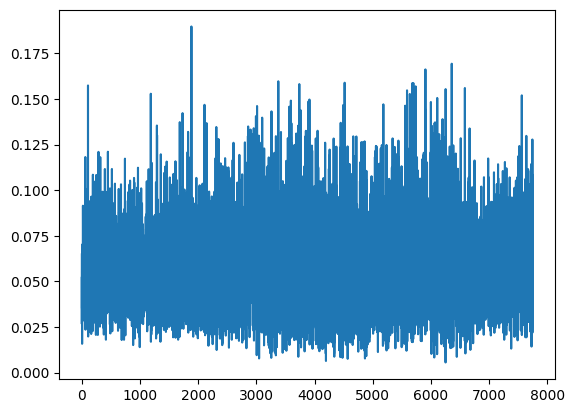

In [17]:
import matplotlib.pyplot as plt

plt.plot(distances)

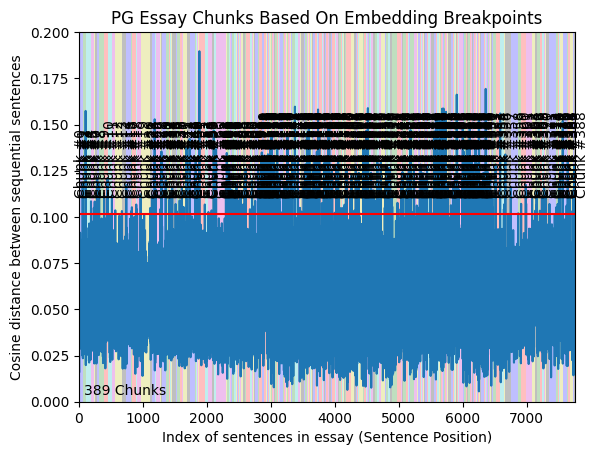

In [18]:
import numpy as np

plt.plot(distances);

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

## チャンク分割

In [19]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

In [20]:
for i, chunk in enumerate(chunks[:2]):
    buffer = 200
    
    print (f"Chunk #{i}")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

Chunk #0
（一） 長い影を地にひいて、痩馬の手綱を取りながら、彼れは黙りこくって歩いた。 大きな汚い風呂敷包と一緒に、章魚のように頭ばかり大きい赤坊をおぶった彼れの妻は、少し跛脚をひきながら三、四間も離れてその跡からとぼとぼとついて行った。 北海道の冬は空まで逼っていた。 蝦夷富士といわれるマッカリヌプリの麓に続く胆振の大草原を、日本海から内浦湾に吹きぬける西風が、打ち寄せる紆濤のように跡から跡から吹き払っ
...
る時の事を思った。 妻は吸い取られるように暖かそうな火の色に見惚れていた。 二人は妙にわくわくした心持ちになった。 蹄鉄屋の先きは急に闇が濃かくなって大抵の家はもう戸じまりをしていた。 荒物屋を兼ねた居酒屋らしい一軒から食物の香と男女のふざけ返った濁声がもれる外には、真直な家並は廃村のように寒さの前にちぢこまって、電信柱だけが、けうとい唸りを立てていた。 彼れと馬と妻とは前の通りに押黙って歩いた。


Chunk #1
歩いては時折り思い出したように立停った。 立停ってはまた無意味らしく歩き出した。 四、五町歩いたと思うと彼らはもう町はずれに来てしまっていた。 道がへし折られたように曲って、その先きは、真闇な窪地に、急な勾配を取って下っていた。 彼らはその突角まで行ってまた立停った。 遙か下の方からは、うざうざするほど繁り合った濶葉樹林に風の這入る音の外に、シリベシ河のかすかな水の音だけが聞こえていた。 「聞いて
...
てた。 彼れはそれにも気を取られていた。 上框に腰をかけていたもう一人の男はやや暫らく彼れの顔を見つめていたが、浪花節語りのような妙に張りのある声で突然口を切った。 「お主は川森さんの縁のものじゃないんかの。どうやら顔が似とるじゃが」 今度は彼れの返事も待たずに長顔の男の方を向いて、 「帳場さんにも川森から話いたはずじゃがの。主がの血筋を岩田が跡に入れてもらいたいいうてな」 また彼れの方を向いて、




In [21]:
len(chunks)

389

## 以下、通常のRAG

In [22]:
# FAISSでベクトルストアを作成
vectorstore = FAISS.from_texts(chunks, embedding)

In [23]:
# SudachiPyの初期設定
tokenizer_obj = dictionary.Dictionary().create()

In [24]:
# OpenAIの言語モデルを設定（ここではGPT-3を使用）
llm = ChatOpenAI(model="gpt-4o", openai_api_key=openai.api_key)

C:\Users\tatsu\AppData\Local\Temp\ipykernel_28204\1591884372.py:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  llm = ChatOpenAI(model="gpt-4o", openai_api_key=openai.api_key)


## Multi-query retriver

In [25]:
# Output parser will split the LLM result into a list of queries
class LineListOutputParser(BaseOutputParser[List[str]]):
    """Output parser for a list of lines."""

    def parse(self, text: str) -> List[str]:
        lines = text.strip().split("\n")
        return list(filter(None, lines))  # Remove empty lines


output_parser = LineListOutputParser()

QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""あなたは AI 言語モデルのアシスタントです。
    あなたのタスクは、指定されたユーザーの質問から5つの異なるバージョンを生成し、 ベクトルデータベースから関連するドキュメントを取得することです。
    ユーザーの質問に対して複数の視点を生成することで、 ユーザーは、距離ベースの類似性検索の制限の一部を克服します。
    これらの代替質問を改行で区切って入力してください。
    元の質問: {question}""",
)

# Chain
llm_chain = QUERY_PROMPT | llm | output_parser

In [26]:
retriever = MultiQueryRetriever(
    include_original=True, retriever=vectorstore.as_retriever(search_kwargs={"k": 10}), llm_chain=llm_chain, parser_key="lines"
)

In [27]:
# Set logging for the queries
import logging

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [28]:
test = retriever.get_relevant_documents(query="競漕会の三日前のレースコースでの結果は、農科と文科でどれくらいの秒数差があったか？")

C:\Users\tatsu\AppData\Local\Temp\ipykernel_28204\2757631913.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  test = retriever.get_relevant_documents(query="競漕会の三日前のレースコースでの結果は、農科と文科でどれくらいの秒数差があったか？")
INFO:langchain.retrievers.multi_query:Generated queries: ['1. 競漕会の三日前に行われたレースで、農科と文科の結果にはどれくらいの時間差がありましたか？', '2. 農科と文科の間で、競漕会三日前のレースコースでの時間差は何秒でしたか？', '3. 競漕会の三日前のレースで、農科と文科が出したタイムの違いはどのくらいでしたか？', '4. 競漕会の三日前に行われたレースでは、農科と文科のタイム差は何秒でしたか？', '5. 農科と文科の競漕会三日前のレース結果の秒数差はどれくらいだったのでしょうか？']


In [29]:
test

[Document(page_content='三 競漕の日はだんだん近づいて来る。 その一週間ほど前に学習院の競漕会があった。 それには文農二科が来賓として混合競漕をするはずになっていた。 混合というのは敵味方の中堅――三番四番――を交換して漕ぐのである。 この時が敵味方初めて正式に顔を合わせるの時であった。 双方の艇は一緒に台船のところで順序の来るのを待っていた。 選手の中では高等学校の関係から知った顔もあるので互いに挨拶などをし合った。 それからまるで艇のこととは関係のない問題を何か話し合っていた。 文科の整調の窪田は農科の舵手の高崎と同じ中学を出て同じく一高に入った親友であった。 しかし高等学校の時からしばしば敵対の地位に立たせられて来たので、何となく疎隔されてしまい、今では二人はまるで外出行きの話しかしなくなってしまった。 二人は出身地方の土語を用いて妙な蟠りのある話を始めた。 それも、 「今年はいつもよりお寒うござすな」というような当り障りのないことを言うのであった。 そしてたまたま艇のことに及んでもお互いに冷たい好意で敵手のことを賞め、わざとらしいまでに自分の方を謙遜した。 彼らはお互いに自分の方を「駄目ですよ、僕の方こそ駄目ですよ」なぞと言い合った。 こうしているうちには誰れでも敵味方で二三言は言葉を交した。 そしてお互いに敵手が案外人の好いのに驚いた。 敵愾心などというものは平凡な発見ではあるが、ある団体間の自欺的邪推であるということが個人個人にはわかった。 物に感じやすい四番の斎藤なぞは漕いでしまってから向うの舵手に「御苦労でした」と言われて今までの敵意をすっかり「隅田川へ流してしまった」と自白したほどであった。 しかし主将たる窪田らの心の中はこの間にも敵の船脚や漕法に注意することを怠らなかった。 彼は競漕の間に自分の艇へ来ている敵の中堅がどれだけ漕力があるか試そうと思って、ラストで思いきり急にピッチを上げて見た。 そして敵手のなかなか侮れないのを知った。 その時の競漕では久野や窪田のいる文科勢の五人の艇の方が勝った。 久野は初めて競漕行路の舵を曳いて見るの機会を得た。 その日のころから練習はいよいよ激しくなって行った。 先輩がしげしげ来て選手を励ましたり、みずから間諜となって敵の選手の漕力を測ったりした。 ある日久野は舵を水原という先輩に頼んで

In [30]:
# 6. 回答を50トークン以内に制限し、引用を含むプロンプトを作成
prompt_template = """あなたは正確性の高いQAシステムです。
事前知識ではなく、常に提供されたコンテキスト情報を使用して質問に回答してください。
以下のルールに従って回答してください。:
1. 事前知識は使わず、コンテキストから得られる情報のみを使用して回答してください。
2. 回答内で指定されたコンテキストを直接参照しないでください。
3. 「コンテキストに基づいて、...」や「コンテキスト情報は...」、またはそれに類するような記述は避けてください。
4. 回答は50トークン以内で簡潔に回答してください。
5. コンテキストから具体的な回答ができない場合は「分かりません」と回答してください。

コンテキスト: {context}
質問: {question}
回答:"""
prompt = PromptTemplate(template=prompt_template, input_variables=["context", "question"])


In [31]:
# 検索用のQAチェーンを構築
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",  # "stuff" モードはシンプルに関連ドキュメントをまとめて渡すモード
    retriever=retriever,
    return_source_documents=True,  # 検索結果としてソースドキュメントを返す
    chain_type_kwargs={"prompt": prompt}
)

## 質問ファイルを読み込んでQ&Aを作成

In [32]:
# 提供されたCSVファイルを読み込み
query_df = pd.read_csv("../data/query.csv", encoding="utf-8")

In [33]:
query_df.head()

,index,problem
0,1,競漕会の三日前のレースコースでの結果は、農科と文科でどれくらいの秒数差があったか？
1,2,骸骨男の正体は誰ですか？作中で言及されている氏名で答えること。
2,3,骸骨男はバスの中に足跡を一切残さずにどうやって抜け出しましたか？
3,4,殺人罪で裁判にかけられた兄が登場しますが、その理由は何ですか？
4,5,小説「芽生」で出てくる国名は何種類ですか？


In [34]:
answers = []
evidences = []

for _, row in query_df.iterrows():
    if _ <= 25:
        print(_)
        query = row["problem"]
        print(query)
        result = qa_chain({"query": query})
        answer = result["result"]
        print(answer)
        evidence = result["source_documents"][0].page_content # 証拠部分を抽出
        answers.append(answer)
        evidences.append(evidence)

0
競漕会の三日前のレースコースでの結果は、農科と文科でどれくらいの秒数差があったか？


C:\Users\tatsu\AppData\Local\Temp\ipykernel_28204\3073282780.py:9: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.
  result = qa_chain({"query": query})
INFO:langchain.retrievers.multi_query:Generated queries: ['1. 競漕会の三日前に行われたレースで、農科と文科のタイム差はどれくらいでしたか？', '2. 三日前の競漕会のレース結果において、農科チームと文科チームの間には何秒の差がありましたか？', '3. レースコースでの試合が行われた競漕会の三日前、農科と文科のタイムの差は何秒でしたか？', '4. 三日前の競漕会におけるレースで、農科と文科の間にはどれほどの秒数の違いがありましたか？', '5. 競漕会の三日前に実施されたレースで、農科と文科のチームのタイム差は具体的に何秒だったのでしょうか？']


5秒の差がありました。
1
骸骨男の正体は誰ですか？作中で言及されている氏名で答えること。


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 作中で言及されている名前で、骸骨男の正体は誰ですか？', '2. 骸骨男の正体として作中で示された人物名は何ですか？', '3. 骸骨男として知られるキャラクターの本名は作中でどのように言及されていますか？', '4. 小説の中で、骸骨男の正体はどのような名前で登場しますか？', '5. 骸骨男の実名は物語の中でどのように記されていますか？']


笠原さんです。
2
骸骨男はバスの中に足跡を一切残さずにどうやって抜け出しましたか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 骸骨男はどのようにしてバス内に足跡を残さずに脱出したのでしょうか？', '2. バスの中で足跡を残さずに骸骨男が逃げた方法は何ですか？', '3. 骸骨男は足跡を一切残さずにバスを去ることができたのはなぜですか？', '4. 骸骨男がバスから足跡を残さずに出た仕組みを教えてください。', '5. バスの中で骸骨男が足跡を残さずに消えた理由は何ですか？']


骸骨男は、バスの床板にあったばね仕掛けの落とし穴を使って抜け出しました。
3
殺人罪で裁判にかけられた兄が登場しますが、その理由は何ですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 殺人罪で告訴された兄が裁判にかけられている理由は何でしょうか？', '2. 殺人罪で訴えられた兄が法廷に立たされている背景は何ですか？', '3. 殺人の容疑で兄が裁判にかけられることになった原因は何でしょうか？', '4. 兄が殺人罪で起訴され、裁判に臨んでいる理由を教えてください。', '5. 殺人罪で兄が法廷に出廷することになった事情は何ですか？']


若い頃、兄は恋人と心中を図り、彼女を短刀で殺害したためです。
4
小説「芽生」で出てくる国名は何種類ですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 小説「芽生」にはどの国名が登場しますか？', '2. 「芽生」という小説に登場する国名はいくつありますか？', '3. 小説「芽生」には何種類の国名が記載されていますか？', '4. 「芽生」の物語で言及されている国名は何ですか？', '5. 小説「芽生」にはどのような国名が登場しているのでしょうか？']


分かりません。
5
武男と浪子のうち、どちらが野外での楽しみをより積極的に表現していますか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 武男と浪子のどちらがアウトドア活動に対してより積極的な姿勢を持っていますか？', '2. 野外での楽しみを追求する際、武男と浪子のうち、どちらがより積極的ですか？', '3. 武男と浪子の中で、野外でのアクティビティを楽しむことにより積極的な人物は誰ですか？', '4. 武男と浪子のどちらが野外での楽しみを大切にしていると感じますか？', '5. 野外活動に対する積極性について、武男と浪子を比較するとどちらがより前向きですか？']


武男がより積極的に野外での楽しみを表現しています。
6
小説「芽生」で、主人公が東京から小諸に帰る時期から、実際に引越しが完了するまでの間はだいたいどのぐらいの日数だと考えられますか？


INFO:langchain.retrievers.multi_query:Generated queries: ['小説「芽生」において、主人公が東京から小諸に引っ越すまでの日数はどのくらいですか？  ', '小説「芽生」で、主人公の引っ越し準備が始まってから完了するまでの期間はどれくらいでしょうか？  ', '「芽生」の主人公が東京から小諸に移動するプロセスは、どの程度の時間がかかりますか？  ', '小説「芽生」では、主人公が東京を離れて小諸に落ち着くまでの時間はどれくらいですか？  ', '「芽生」のストーリーで、主人公が東京から小諸への引っ越しを完了するまでの日数はおおよそどれくらいですか？']


分かりません。
7
「競漕」の中で、文科のボート部メンバーが実際に酒を飲むシーンは何回か？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 競漕の中で、文科のボート部メンバーがお酒を飲むシーンは何回登場しますか？', '2. 文科のボート部が競漕中に実際に飲酒する場面は作中で何度描かれていますか？', '3. 競漕において、文科のボート部メンバーが酒を飲む描写は作品中で何回ありますか？', '4. 文科のボート部が競漕で酒を飲むシーンは、ストーリー内で何度ありますか？', '5. 作中の競漕において、文科のボート部のメンバーが酒を飲む場面は何回ありますか？']


1回です。
8
文中に登場するカタカナ表記された北海道の地名を全て挙げてください。


INFO:langchain.retrievers.multi_query:Generated queries: ['北海道に関連するカタカナ地名をすべて教えてください。  ', '北海道にあるカタカナで表記される地名をリストアップしてください。  ', '文中に出てくるカタカナ表記の北海道の地名をすべてピックアップしてください。  ', '北海道に関するカタカナ地名を文章中からすべて探してください。  ', '北海道でカタカナ表記されている地名を文章内で見つけてください。']


分かりません。
9
兄が情死を試みた時点から、実際に死亡するまでおよそ何年経過したと考えられますか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 兄が情死を試みた後、実際に亡くなるまでにはどのくらいの年月が経過したのでしょうか？', '2. 兄が情死を図った時点から亡くなるまでの年数はどれくらいですか？', '3. 情死未遂から兄が亡くなるまでに経過した年数はどのくらいですか？', '4. 兄が情死を試みた後、実際に死亡するまでの期間はおよそ何年ですか？', '5. 兄の情死未遂から実際に亡くなるまでにどれくらいの時間が経ったのでしょうか？']


約七年が経過したと考えられます。
10
お房が小諸を出発した日に一緒に出かけた友達は誰でしたか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. お房が小諸を出発する際に同行した友達の名前は何ですか？', '2. 小諸を離れる日にお房と一緒にいた友達は誰ですか？', '3. お房が小諸を出発したときに同行したのはどの友達ですか？', '4. 小諸を出発する日にお房に同行した友人は誰だったのでしょうか？', '5. お房が小諸を去る日に共に旅立った友達は誰ですか？']


分かりません。
11
サーカス団の楽屋にいるライオンの数は合計何匹ですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['- サーカスの楽屋には何匹のライオンがいるのでしょうか？', '- サーカス団の控室には合計何頭のライオンがいるのですか？', '- サーカスの裏方エリアには、全部で何頭のライオンがいるのか教えてください。', '- サーカスのバックヤードにはライオンは全部で何匹いるのか？', '- サーカス団の舞台裏にいるライオンの総数を知りたいです。']


3匹です。
12
死生に関するいくつかの断想に登場する二人の兄弟のうち、より健康だったのはどちらですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 「死生に関するいくつかの断想」に登場する二人の兄弟のうち、どちらが健康的でしたか？', '2. 「死生に関するいくつかの断想」の中で、兄弟二人の健康状態を比較すると、どちらが優れていますか？', '3. 「死生に関するいくつかの断想」に登場する兄弟の中で、健康面で優れていたのはどちらですか？', '4. 「死生に関するいくつかの断想」において、健康がより良好だった兄弟はどちらですか？', '5. 「死生に関するいくつかの断想」で描かれる兄弟の健康状態は、どちらがより良かったのでしょうか？']


より健康だったのは、歳下の弟で、人力車夫として一家を支えていた方です。
13
笠原正一君が見た恐ろしい夢の内容は何ですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['笠原正一君が体験した悪夢の詳細を教えてください。  ', '笠原正一君が夢の中で何を見たのか知りたいです。  ', '笠原正一君が目覚めた後に語った恐ろしい夢とはどんなものでしたか？  ', '笠原正一君が見た夢の内容が恐ろしいとされた理由は何ですか？  ', '笠原正一君が経験した恐ろしい夢について詳しく説明してください。']


正一君は、薄暗い空から骸骨の首が豆粒のように降ってきて、それがどんどん大きくなり、頭上に落ち続ける夢を見ました。ピンポン球の大きさから、やがて骸骨の顔が押しつぶさんばかりに近づき、恐ろしい口が開いて肩に食いつくという恐怖の夢でした。
14
馬に乗った骸骨男を見つけてから、明智が投げ縄をするまでに縮めた差は何メートルだと考えられますか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 馬に乗った骸骨男を見つけた後、明智が投げ縄を使うまでに縮めた距離は何メートルですか？', '2. 骸骨男が馬に乗っているのを発見してから、明智が投げ縄を投げるまでの間に縮まった距離はどれくらいでしょうか？', '3. 明智が馬に乗った骸骨男を見た後、投げ縄を投げるまでにどのくらいの距離を縮めたと考えられますか？', '4. 骸骨男が馬に乗っているのを見た後、明智がどれだけの距離を縮めてから投げ縄を投げたと思いますか？', '5. 明智が馬に乗った骸骨男を目撃してから、投げ縄をするまでの距離の縮まり具合をメートル単位で教えてください。']


分かりません。
15
染物屋で広げられた絹や綿の長い布に関して描写されている色を全て挙げてください。（読点区切り）


INFO:langchain.retrievers.multi_query:Generated queries: ['染物屋で広げられている絹や綿の布に描かれている色を詳しく教えてください。（読点区切り）  ', '染物屋にある絹や綿の長い布に使用されている色を全て列挙してください。（読点区切り）  ', '染物屋で展示されている絹と綿の布に見られる色を詳述してください。（読点区切り）  ', '染物屋で扱っている絹や綿の布に用いられている色の種類を全て教えてください。（読点区切り）  ', '染物屋の絹や綿の布に関して、使用されている色をすべて教えてください。（読点区切り）']


濃紺、紫、バラ色、薄青、パールグレイ。
16
主人公が「最後の晩餐（ばんさん）！」と思った理由はなんですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 物語の中で主人公が「最後の晩餐！」と考えた背景や理由は何ですか？', '2. 主人公が「最後の晩餐！」と思うに至った状況を教えてください。', '3. なぜ主人公はその場面で「最後の晩餐！」と心に浮かべたのでしょうか？', '4. 主人公が「最後の晩餐！」と感じたきっかけや出来事は何ですか？', '5. どのような理由で主人公は「最後の晩餐！」という考えに至ったのか、詳しく説明してください。']


分かりません。
17
少年探偵団のメンバーで捜査に協力した人々で名前が作中で言及されている人たちを全て答えてください(読点区切り、苗字のみ)


INFO:langchain.retrievers.multi_query:Generated queries: ['少年探偵団の捜査に協力した登場人物の名前を、作中で言及されている苗字を読点で区切って教えてください。  ', '少年探偵団のメンバーで、作中に登場し捜査に関与した人物の苗字をすべて列挙してください。  ', '少年探偵団の捜査を手伝った人物の名前を、作中で言及されている苗字のみ、読点で区切ってください。  ', '作中で少年探偵団に協力したキャラクターの苗字をすべて教えてください、読点で区切ってください。  ', '少年探偵団に捜査協力した人物の苗字を、作中で言及されているものすべて挙げてください。']


小林、井上、野呂
18
「万右衛門」という名前は何回登場しますか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 「万右衛門」という名前が登場する回数を教えてください。', '2. 「万右衛門」という名前はどれくらいの頻度で使われていますか？', '3. 文中で「万右衛門」という名前が出てくるのは何回ですか？', '4. 「万右衛門」という名前の出現数を確認してください。', '5. テキスト内に「万右衛門」という名前が何回出現するか教えてください。']


分かりません。
19
染物屋の家族が、泥棒から身を守ることができた理由は何ですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 染物屋の家族は、どのようにして泥棒から身を守ることができたのでしょうか？', '2. なぜ染物屋の家族は泥棒から身を守ることができたのですか？', '3. 染物屋の家族が泥棒から身を守るために取った方法は何ですか？', '4. 染物屋の家族は泥棒から身を守るためにどんな手段を講じたのですか？', '5. 染物屋の家族が泥棒を防ぐことができたのは、どんな理由があったからですか？']


分かりません。
20
小説「芽生」で、 主人公が借りることができた庭に植えられていたものとして描写している植物を全てあげてください。（読点区切り）


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 小説「芽生」で、主人公が借りた庭に植えられていた植物を全て教えてください。', '2. 「芽生」という小説で、主人公が借りた庭に描かれている植物の種類をリストアップしてください。', '3. 小説「芽生」の中で、主人公が使える庭に植えられている植物について教えてください。', '4. 「芽生」という作品において、主人公が借りた庭に存在する植物を全て挙げてください。', '5. 小説「芽生」で、主人公が借りた庭に植えられている植物は何がありますか。']


分かりません。
21
ノロちゃんの本名は？


INFO:langchain.retrievers.multi_query:Generated queries: ['ノロちゃんの正式な名前を教えてください。  ', 'ノロちゃんの本名は何ですか？  ', 'ノロちゃんの名前のフルネームを知りたいです。  ', 'ノロちゃんの別名や本名はありますか？  ', 'ノロちゃんの正式なフルネームは何でしょうか？']


分かりません。
22
今年の春季に開かれる大学のボート大会の文科メンバーの中で、名前が公表されている全員をあげてください。（苗字のみ、読点区切り）


INFO:langchain.retrievers.multi_query:Generated queries: ['今年の春季に開催される大学のボート大会で、文科系メンバーとして名前が発表されている人の苗字を教えてください。（読点で区切って）  ', '今年春に行われる大学ボート大会の文科メンバーで、名前が公表されている方々の苗字を列挙してください。（読点使用）  ', '大学ボート大会春季開催時に文科メンバーとして名前が公表されている方々の苗字を挙げてください。（読み仮名は不要、読点区切り）  ', '春季の大学ボート大会において、文科のメンバーとして名前が発表された人々の苗字をリストしてください。（読点で区切る）  ', '今年春に開かれる大学のボート大会で、文科系メンバーとして名前が公表されている人々の苗字をすべて挙げてください。（読点を使って区切る）']


浅沼、小林、窪田、津島、久野、水原、早川、斎藤
23
文中での「大豆」という文字の登場回数は何回ですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. テキストの中に「大豆」という単語は何回出現していますか？', '2. ドキュメント内で「大豆」が記載されている回数を教えてください。', '3. 文章中に「大豆」という言葉は何回登場しますか？', '4. 「大豆」という表現が文中で使われている頻度はどれくらいですか？', '5. そのテキストには「大豆」という言葉が何度出てきますか？']


2回です。
24
久野が舵手として参加することになった春季に開かれる大学のボート大会の勝者は、何科ですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 春季に開催される大学のボート大会で、久野が舵手として参加するチームの勝者はどの学科ですか？', '2. 久野が舵手を務める春の大学ボート大会で優勝したチームは、どの学部に属していますか？', '3. 大学の春季ボート大会で久野が舵手を担当したチームの勝利者は、どの専門分野の学生ですか？', '4. 久野が舵手として出場する春の大学ボート大会で勝利を収めたのは、どの学科のチームですか？', '5. 春に行われる大学ボート大会で久野が舵手を務めるチームの勝者は、どの学科の生徒ですか？']


文科です。
25
骸骨男にさらわれたのは正一君とミヨ子ちゃんのどちらですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 骸骨男に誘拐されたのは正一君でしょうか、それともミヨ子ちゃんでしょうか？', '2. 正一君とミヨ子ちゃんのうち、骸骨男に連れ去られたのはどちらですか？', '3. 骸骨男の手にかかったのは正一君ですか、それともミヨ子ちゃんですか？', '4. 骸骨男によってさらわれたのは正一君ですか、それともミヨ子ちゃんですか？', '5. 骸骨男に捕まったのは正一君とミヨ子ちゃんのどちらなのか教えてください。']


正一君が骸骨男にさらわれました。


In [35]:
for _, row in query_df.iterrows():
    if (_ > 25) & (_ <= 50):
        print(_)
        query = row["problem"]
        print(query)
        result = qa_chain({"query": query})
        answer = result["result"]
        print(answer)
        evidence = result["source_documents"][0].page_content # 証拠部分を抽出
        answers.append(answer)
        evidences.append(evidence)

26
大学の競漕会にて、文科と農科、どちらの方が先にリードを奪いましたか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 大学の競漕会では、文科と農科のどちらが最初にリードを取ったのでしょうか？', '2. 文科と農科の競漕会で、どちらのチームが先にリードを奪ったか教えてください。', '3. 大学のボートレースで、文科と農科のどちらがリードを始めに取ったか知りたいです。', '4. 文科と農科が参加した大学のレースで、先にリードを奪ったのはどちらの学部ですか？', '5. 大学の競漕大会で、最初にリードを取ったのは文科と農科のどちらですか？']


文科が農科より先にリードを奪いました。
27
婦人が見た夕景色はどの地域ですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 女性が見た夕焼けの美しい景色はどこの地域ですか？', '2. 婦人が目にした夕方の風景はどの場所にありますか？', '3. ある女性が観賞した夕暮れの絶景はどの地域で見られたのでしょうか？', '4. どの場所で婦人は印象的な夕景を楽しんだのでしょう？', '5. 女性が感動した夕日の景色はどの地域に存在しますか？']


分かりません。
28
骸骨男が最初に行った殺人はどこでしたか？


INFO:langchain.retrievers.multi_query:Generated queries: ['骸骨男が最初に犯した殺人事件の場所はどこですか？  ', '骸骨男の最初の殺人が起こった場所はどこでしょうか？  ', '骸骨男による最初の殺人事件はどこで発生しましたか？  ', '骸骨男が初めて殺人を行ったのはどこの地域ですか？  ', '骸骨男が関与した最初の殺人事件の現場はどこですか？']


分かりません。
29
小説「芽生」の主人公が東京に行ったのは主に何のためですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 小説「芽生」では、主人公が東京に行く主な理由は何ですか？', '2. 「芽生」の主人公が東京を訪れる目的は何でしょうか？', '3. 小説「芽生」における主人公の東京行きの目的は具体的に何ですか？', '4. 「芽生」の物語で、主人公が東京を目指す主要な動機は何ですか？', '5. 小説「芽生」で、主人公が東京に向かう背景にはどんな理由がありますか？']


主人公が東京に行ったのは、家を探すためです。
30
小林君はどのようにして骸骨男の秘密を探りだしたのですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 小林君はどのような方法で骸骨男の秘密を解明したのでしょうか？', '2. 骸骨男の秘密を暴くために、小林君はどんな手順を踏んだのですか？', '3. 小林君は骸骨男の謎を解決するためにどのようなアプローチを取ったのですか？', '4. 骸骨男の秘密を知るために、小林君が行った調査手法は何ですか？', '5. 小林君は骸骨男についてどのような情報収集を行ったのですか？']


小林君はこじき少年に変装し、腹話術師のトランクに隠れているのを見つけ、地下室での秘密を探り出しました。
31
掃除されたと考えられる井戸がありますが、それは何月に行われたでしょうか？


INFO:langchain.retrievers.multi_query:Generated queries: ['井戸の清掃は何月に実施されたのでしょうか？  ', '井戸の掃除が行われた月について教えてください。  ', '井戸が掃除されたのはどの月だったのか知りたいです。  ', '井戸の清掃が実施された月を特定できますか？  ', '井戸が清掃されたのは具体的に何月ですか？']


7月に井戸の掃除が行われたようです。
32
仁右衛門が北海道を離れて始めた新しい生活は何ですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['仁右衛門が北海道を出た後に始めた新しい生活とはどのようなものですか？  ', '仁右衛門が北海道を離れてからどのような新生活を始めたのですか？  ', '北海道を去った仁右衛門はどのような新たな人生を歩み始めましたか？  ', '仁右衛門が北海道を離れた後、彼はどのような新生活を送っているのですか？  ', '北海道を離れた仁右衛門が始めた新しい生活の詳細を教えてください。']


分かりません。
33
婦人の容姿を特徴づける要素を全て挙げてください。（読点区切り）


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 女性の外見を特徴づける要素をすべて列挙してください。（読点で区切ってください）', '2. 女性の容姿に関連する特徴をすべて挙げてください。（読点で区切ってください）', '3. 婦人の外見に関する特徴を網羅的に記述してください。（読点を用いて）', '4. 女性の容姿を特徴づける要素を詳細に挙げてください。（読点で区切ってください）', '5. 婦人の容姿に関するすべての特徴をリストアップしてください。（読点で区切ってください）']


色白の細面、眉の間ややせまりて、頬のあたりの肉寒げ、瘠形のすらりとしおらしき人品
34
骸骨男が煙のように消えた場面として具体的に描写されたシーンは合計何回ありましたか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 骸骨男が煙のように消えるシーンは、具体的に何回描写されていますか？', '2. 骸骨男が煙のように消える描写は、作品中で何度描かれていますか？', '3. 骸骨男が煙のように消えたシーンは、全体で何回登場しますか？', '4. 骸骨男が煙のように消える場面は、合計でどれくらいの回数描写されていますか？', '5. 骸骨男が煙のように消える瞬間は、作中で何回具体的に出てきますか？']


分かりません。
35
私にメガネを作ってくれた老人が死んだことが手紙の内容から判明したのは何月何日ですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. メガネを作ってくれた老人が亡くなったことが手紙でわかったのは何月何日ですか？', '2. 手紙の内容から、メガネ職人の老人の死を知ったのは具体的にいつですか？', '3. 手紙によってメガネを作成してくれた老人の訃報が明らかになった日はいつですか？', '4. 老人が亡くなったことを伝える手紙を受け取ったのは何月何日ですか？', '5. メガネを作ってくれた老人の死を手紙から知ったのはどの日付ですか？']


分かりません。
36
小作人となった主人公のおおよその身長は？


INFO:langchain.retrievers.multi_query:Generated queries: ['主人公が小作人になったときの身長はどれくらいですか？  ', '小作人となった主人公の身長はどのくらいか教えてください。  ', '主人公が小作人として働いているときの身長のおおよそは？  ', '小作人になった主人公の背の高さはどれくらいですか？  ', '主人公が小作人として活動している際の身長はおおよそどれくらいですか？']


分かりません。
37
浅沼が辞退した時の文科の艇長の元親友の農科の舵手はだれか？（苗字のみ）


INFO:langchain.retrievers.multi_query:Generated queries: ['浅沼が辞退した際の文科の艇長の元親友である農科の舵手は誰か？（苗字のみ）  ', '浅沼が辞退したとき、文科の艇長の旧友である農科の舵手の苗字は何ですか？  ', '浅沼が辞退した際に、文科の艇長と親しかった農科の舵手の苗字を教えてください。  ', '浅沼が辞退した場合に、文科の艇長と友人だった農科の舵手は誰でしょうか？（苗字のみ）  ', '浅沼が辞退した時点で、文科の艇長の元友人である農科の舵手の苗字は？']


高崎
38
片岡中将の体重は何キログラムですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['片岡中将の体重についての情報を教えてください。  ', '片岡中将の体重は何kgか知っていますか？  ', '片岡中将が何キログラムの体重を持っているか教えていただけますか？  ', '片岡中将の体重に関する詳細を教えてください。  ', '片岡中将の体重はどのくらいですか？']


片岡中将の体重は約82.5キログラムです。
39
「サーカスの怪人」の作中に実物として登場する動物は全部で何種類ですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['「サーカスの怪人」に登場する動物は何種類ありますか？  ', '「サーカスの怪人」において、実際に描かれている動物の数はどれくらいでしょうか？  ', '「サーカスの怪人」では、どんな動物が具体的に登場していますか？  ', '「サーカスの怪人」に出てくる動物の種類は何がありますか？  ', '「サーカスの怪人」に実際に登場する動物の数を教えてください。']


作中に登場する動物は、ライオン、トラ、ヒョウ、クマ、ゾウの5種類です。
40
お房が病院に来てから何週間目に耳がよく聞こえなくなりましたか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. お房は病院に来てから何週間後に耳が聞こえにくくなったのですか？', '2. お房の耳の聴力が低下したのは、病院に来て何週間経った時ですか？', '3. 病院での滞在中、お房の耳が聞こえにくくなったのは何週目ですか？', '4. お房が病院に来院してから耳が聞こえなくなったのは何週目でしたか？', '5. お房が病院に来てから耳の聴力が悪化したのは何週間後のことですか？']


お房は病院に来てから二週間目に耳がよく聞こえなくなりました。
41
仁右衛門の妻と与十の妻のうち、体格がよいと言及されているのはどちらですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['仁右衛門の妻と与十の妻のうち、体格について言及されているのはどちらですか？  ', '仁右衛門の妻と与十の妻のうち、どちらの体格について詳細が述べられていますか？  ', '仁右衛門の妻と与十の妻の体格に関する情報は、どちらに多く見られますか？  ', '仁右衛門の妻と与十の妻の中で、体格についての特徴が記載されているのは誰ですか？  ', '仁右衛門の妻と与十の妻の体格について、具体的な記述があるのはどちらですか？']


与十の妻です。
42
川島武男は佐世保で赤道直下の強烈な太陽にさらされて日射病になりましたが、どのように回復しましたか？


INFO:langchain.retrievers.multi_query:Generated queries: ['川島武男は佐世保で日射病になった後、どのような方法で回復しましたか？  ', '川島武男が赤道直下の強烈な太陽による日射病から回復したプロセスは何ですか？  ', '佐世保で日射病にかかった川島武男は、どのような回復策をとったのでしょうか？  ', '日射病にかかった川島武男は、どのようにして健康を取り戻したのですか？  ', '川島武男は強烈な太陽の影響で日射病になりましたが、その後どのようにして治療を受けたのですか？']


分かりません。
43
笠原団長の依頼を受け、少年探偵団と警察が骸骨男を捜索していた時に小林君が隠れていた場所はどこですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 笠原団長の依頼で、少年探偵団と警察が骸骨男を追っていた際、小林君はどこに身を潜めていましたか？', '2. 少年探偵団と警察が笠原団長の依頼で骸骨男を探していた時、小林君が隠れていたのはどこですか？', '3. 笠原団長の要請で、骸骨男を探す少年探偵団と警察の捜査中に、小林君が身を潜めた場所はどこでしたか？', '4. 骸骨男を捜索するために笠原団長の依頼を受けた少年探偵団と警察の活動中、小林君はどこに隠れていたのでしょうか？', '5. 笠原団長の任務で、少年探偵団と警察が骸骨男を追っている最中に、小林君が隠れていた場所はどこだったのですか？']


分かりません。
44
千々岩が恨みを抱いた人物を全て挙げてください。（読点区切り）


INFO:langchain.retrievers.multi_query:Generated queries: ['千々岩はどの人物に対して恨みを持っていたか、全員を教えてください。（読点で区切ってください）  ', '千々岩が敵対心を抱いていた人物をすべて挙げてもらえますか。（読点で区切ってください）  ', '千々岩が憎んでいた人々を一覧で示してください。（読点で区切ってください）  ', '千々岩が恨みを持った相手をすべて教えてください。（読点で区切ってください）  ', '千々岩が嫌悪感を持っていた相手を全て教えてください。（読点で区切ってください）']


中将、浪子、武男。
45
仁右衛門が村に到着したときに持っていた家畜は何ですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['仁右衛門が村に来た際に連れていた動物は何ですか？  ', '仁右衛門が村に着いたとき、彼が所有していた家畜はどんなものでしたか？  ', '村に到着した際、仁右衛門が持っていた家畜の種類は何ですか？  ', '仁右衛門が村に来たときに同行していた家畜は何ですか？  ', '村に到着した際に仁右衛門が連れていた動物は何でしたか？']


馬です。
46
作中に登場する通訳者の名前は？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. その作品に出てくる通訳者の名前は何ですか？', '2. 物語に登場する通訳者のキャラクターは誰ですか？', '3. 作品内で通訳者として描かれている人物の名前は？', '4. 話の中で通訳者として紹介される人の名前を教えてください。', '5. そのストーリーに登場する通訳者の名前を知りたいです。']


分かりません。
47
早川が競漕に参加しなかった理由は卒業論文ですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 早川が競漕に参加しなかったのは卒業論文のせいですか？', '2. 早川が競漕を欠席した理由は卒業論文に関係していますか？', '3. 卒業論文のために早川は競漕を見送ったのですか？', '4. 早川が競漕に出られなかった原因は卒業論文だったのでしょうか？', '5. 競漕に早川が参加しなかったのは、卒業論文が理由ですか？']


分かりません。
48
作中で婦人は何歳くらいだと描写されていますか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 作品の中で登場する婦人は何歳くらいだとされていますか？', '2. 作中に出てくる婦人の年齢についての描写はどのようになっていますか？', '3. その物語の中で婦人はどのくらいの年齢として描かれていますか？', '4. 婦人の年齢について、作中ではどのように記述されていますか？', '5. 物語の中で描かれている婦人の年齢はどの程度ですか？']


婦人は十八歳から十九歳くらいだと描写されています。
49
「へへ…」（への回数は問わない）という笑い声が登場する回数は何回ですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 「へへ…」という笑い声が出てくるシーンは何度ありますか？', '2. 「へへ…」という笑い方が使用されている箇所はどれくらいありますか？', '3. テキスト内で「へへ…」と笑う部分は全部で何回ありますか？', '4. 「へへ…」という表現が含まれる場面はどのくらいの頻度で出てきますか？', '5. 「へへ…」と笑う音声が記録されている回数は何回でしょうか？']


「へへ…」という笑い声は、3回登場しています。
50
カインの末裔の舞台となる都道府県はどこですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['「カインの末裔」の物語の舞台となっている都道府県はどこですか？  ', '「カインの末裔」の設定されている地域は日本のどの都道府県ですか？  ', '「カインの末裔」のストーリーが展開される場所はどの都道府県ですか？  ', '「カインの末裔」の舞台となる場所は日本のどこですか？  ', '「カインの末裔」の物語の背景となっている都道府県はどこですか？']


分かりません。


In [36]:
for _, row in query_df.iterrows():
    if _ > 50:
        print(_)
        query = row["problem"]
        print(query)
        result = qa_chain({"query": query})
        answer = result["result"]
        print(answer)
        evidence = result["source_documents"][0].page_content # 証拠部分を抽出
        answers.append(answer)
        evidences.append(evidence)

51
作中の人力車夫の弟が、1ヶ月（30日）働いたときの人力車のレンタル代はいくらですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 作中の人力車夫の弟が1ヶ月間働いた際に支払った人力車のレンタル費用はどれくらいですか？', '2. 作中で、人力車夫の弟が1ヶ月（30日）間の労働で必要とした人力車のレンタル料金はどのくらいですか？', '3. 物語の中で登場する人力車夫の弟が30日間働く際のレンタル代金はいくらになりますか？', '4. 作品内で人力車夫の弟が1ヶ月間使用した人力車のレンタル費用について教えてください。', '5. 小説に登場する人力車夫の弟が、1ヶ月間の労働で人力車のレンタルにかかる費用はどの程度ですか？']


分かりません。
52
利子が単利で計算されるものとした場合、3年間小作料を滞納すると支払うべき利子の総額は1反歩あたりいくらになりますか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 単利で計算される場合、3年間小作料を滞納した際の1反歩あたりの利子総額はいくらになりますか？', '2. 小作料が3年間未払いで、単利計算が適用される場合、1反歩ごとの利子はどれくらい発生しますか？', '3. 1反歩あたりの小作料に対して、単利で3年間の滞納利子を計算すると総額はいくらになりますか？', '4. 3年分の小作料滞納に対して単利計算をした場合、1反歩ごとに支払う利子はどのくらいになりますか？', '5. 単利方式で計算されると仮定して、3年間小作料を支払わなかった場合の利子総額は1反歩あたりいくらになりますか？']


分かりません。
53
骸骨男が犯行に使った魔法の種類は？


INFO:langchain.retrievers.multi_query:Generated queries: ['骸骨男はどんな魔法を使って犯行を行ったのですか？  ', '骸骨男が利用した魔法の種類を教えてください。  ', '犯行において骸骨男が使用した魔法は何ですか？  ', '骸骨男が犯罪に使った魔法のタイプは何ですか？  ', '骸骨男が犯行で使用した魔法はどのようなものですか？']


分かりません。
54
文科チームの合宿所は、どんな店名の料理屋の裏手になるか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 文科チームの合宿所は、どの料理店の裏にあるのか？', '2. 文科チームの合宿所の位置は、どの店の裏手に当たる？', '3. 文科チームの合宿所は、どのような名前のレストランの裏に位置している？', '4. 文科チームの合宿所は、どんな料理屋さんの裏手にあるのか？', '5. 文科チームの合宿所の裏手にある店の名前は何ですか？']


分かりません。
55
作中で描写されている巨大なトンボの装飾品の大きさは、おおよそ何センチメートルですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 物語に登場する巨大なトンボの装飾品は、どれくらいの大きさですか？', '2. 作中の巨大なトンボのデコレーションは、どのくらいの長さがあるのでしょうか？', '3. 巨大なトンボの装飾品のサイズは、作品中でどのように描写されていますか？', '4. 物語における巨大なトンボのデコレーションの寸法は、おおよそどれくらいですか？', '5. 作中で言及されているトンボの大きな装飾品は、何センチメートルくらいですか？']


100センチメートルです。
56
山木兵造の妻がお豊に関する悩みに対して、山木兵造が提案した解決策はなんですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 山木兵造は、妻のお豊の悩みにどう対処しようと提案しましたか？', '2. お豊に関する問題に対し、山木兵造が示した解決策はどのようなものでしたか？', '3. 山木兵造が妻のお豊に関する悩みに対して提案した方法は何ですか？', '4. 山木兵造は、お豊に関する悩みをどのように解決しようとしましたか？', '5. お豊に関する悩みに対して、山木兵造がとった具体的な対策はありますか？']


山木兵造は、娘のお豊を連れて京都に行くことを提案しました。
57
武男と浪子のどちらが先に湯に入っていますか？


INFO:langchain.retrievers.multi_query:Generated queries: ['武男と浪子のどちらが先にお風呂に入っていますか？  ', '温泉で最初に入浴するのは武男ですか、それとも浪子ですか？  ', '最初に湯船に入るのは武男と浪子のどちらですか？  ', '武男と浪子の中で、先にお湯に浸かるのはどちらでしょうか？  ', 'お風呂に入る順番は武男と浪子のどちらが先ですか？']


分かりません。
58
婦人が着ていた被布の色は何色ですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. 婦人が着用していた被布の色はどんな色でしたか？', '2. 被布を着ていた婦人の服の色は何でしたか？', '3. 婦人が身に着けていた被布はどのような色合いでしたか？', '4. 婦人の被布の色は具体的に何色だったのでしょうか？', '5. 婦人が着ている被布のカラーは何色ですか？']


草色です。
59
お菊とお繁、新しい環境でも元気だったのはどちらですか？


INFO:langchain.retrievers.multi_query:Generated queries: ['1. お菊とお繁では、新しい環境に順応しやすいのはどちらですか？', '2. 新しい環境で活発に過ごしているのは、お菊とお繁のどちらですか？', '3. 環境が変わっても元気を維持できたのは、お菊とお繁のどちらか教えてください。', '4. お菊とお繁のうち、新しい環境でより適応力を示したのはどちらですか？', '5. 新たな場所での生活で、お菊とお繁のどちらがより健康に過ごしていますか？']


分かりません。


In [37]:
# DataFrameに回答と証拠を追加
query_df['full_answer'] = answers
query_df['evidence'] = evidences

In [38]:
replace_dict = {
        "\n": "",
        "\r": "",
    }

query_df = query_df.replace(
        {"evidence": replace_dict},
        regex=True
    )

In [39]:
query_df.head(10)

,index,problem,full_answer,evidence
0,1,競漕会の三日前のレースコースでの結果は、農科と文科でどれくらいの秒数差があったか？,5秒の差がありました。,三 競漕の日はだんだん近づいて来る。 その一週間ほど前に学習院の競漕会があった。 それには文...
1,2,骸骨男の正体は誰ですか？作中で言及されている氏名で答えること。,笠原さんです。,「アッ、骸骨……。」 それは、あの骸骨男でした。 いつも着ているオーバーや洋服をぬいで、はだ...
2,3,骸骨男はバスの中に足跡を一切残さずにどうやって抜け出しましたか？,骸骨男は、バスの床板にあったばね仕掛けの落とし穴を使って抜け出しました。,とつぶやいています。 「骸骨男がいなくなったのですか。」 井上君が、たずねます。 「うん、い...
3,4,殺人罪で裁判にかけられた兄が登場しますが、その理由は何ですか？,若い頃、兄は恋人と心中を図り、彼女を短刀で殺害したためです。,そして、仏様に捧げる祈りの文句を繰り返した。 木魚の音や読経は数時間続いた。 それらが終わっ...
4,5,小説「芽生」で出てくる国名は何種類ですか？,分かりません。,十の一 四月あまり過ぎたり。 霜に染みたる南天の影長々と庭に臥す午後四時過ぎ、相も変わらず肥...
5,6,武男と浪子のうち、どちらが野外での楽しみをより積極的に表現していますか？,武男がより積極的に野外での楽しみを表現しています。,「僕は一人で歩く方が勝手だ」 これほど手強く打ち払えばいかなる強敵も退散すべしと思いきや、な...
6,7,小説「芽生」で、主人公が東京から小諸に帰る時期から、実際に引越しが完了するまでの間はだいたい...,分かりません。,「いいえ、ちょっとも疲れはいたしません。どうかお話し遊ばして」 茶を入れかえて、幾は次に立ち...
7,8,「競漕」の中で、文科のボート部メンバーが実際に酒を飲むシーンは何回か？,1回です。,そしていつもよりは活気づいて艇庫に船を蔵めた。 夕飯には褒賞の意味で窪田が特別に一人約二合ほ...
8,9,文中に登場するカタカナ表記された北海道の地名を全て挙げてください。,分かりません。,海は実に凪げるなり。 近午の空は天心にいたるまで蒼々と晴れて雲なく、一碧の海は所々練れるよう...
9,10,兄が情死を試みた時点から、実際に死亡するまでおよそ何年経過したと考えられますか？,約七年が経過したと考えられます。,そして、仏様に捧げる祈りの文句を繰り返した。 木魚の音や読経は数時間続いた。 それらが終わっ...


In [40]:
# LLMを使って要約を行う関数
def summarize_answer(problem: str, full_answer: str, evidence: str) -> str:

    summarize_prompt = PromptTemplate(
        input_variables=["problem", "full_answer", "evidence"],
        template=
            """以下のQuestionに対するAnswerの文章をEvidenceを元に50文字以内に収まるように簡潔に答え直してください。
            50文字以内に収まらない場合、要約して一言で答えてください。
            回答だけを答えてください。
                f"Question: {problem}\n\n"
                f"Answer: {full_answer}\n"
                f"Evidence: {evidence}\n"
            回答:"""
    )
    chain = summarize_prompt | llm

    response = chain.invoke(
        {"problem": problem, "full_answer": full_answer, "evidence": evidence}
    )
    return response.content

In [41]:
# tiktokenとgpt-4のトークナイザーを取得
enc = tiktoken.encoding_for_model("gpt-4-2024-08-06")

# query_df の "answer" 列のトークン数を計算し、50トークンを超える場合は要約を行う関数
def check_and_summarize_answers(query_df: pd.DataFrame) -> pd.DataFrame:
    def summarize_if_needed(problem: str, full_answer: str, evidence: str) -> str:
        # トークン数を計算
        token_count = len(enc.encode(full_answer))
        print(token_count)
        
        # トークン数が50を超えた場合は要約する
        if token_count > 50:
            # LLMを使って要約
            summarized_answer = summarize_answer(problem, full_answer, evidence)
            return summarized_answer
        return full_answer

    # "answer" 列に対して処理を適用
    query_df["answer"] = query_df["full_answer"]
    for i in range(len(query_df.index)):
        query_df["answer"][i] = summarize_if_needed(query_df["problem"][i], query_df["full_answer"][i], query_df["evidence"][i])
    return query_df

In [42]:
query_df = check_and_summarize_answers(query_df)

9
6
44
39
7
28
7
4
7
18
7
5
39
136


C:\Users\tatsu\AppData\Local\Temp\ipykernel_28204\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_df["answer"][i] = summarize_if_needed(query_df["problem"][i], query_df["full_answer"][i], query_df["evidence"][i])
C:\Users\tatsu\AppData\Local\Temp\ipykernel_28204\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_df["answer"][i] = summarize_if_needed(query_df["problem"][i], query_df["full_answer"][i], query_df["evidence"][i])
C:\Users\tatsu\AppData\Local\Temp\ipykernel_28204\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

7
25
7
12
7
7
7
7
38
4
4
19
18
7
7
23
59
20
7
49
7
7
7
4
20
37
33
8
7
7
11
4
7
7
26
21
7
7
7
7
7
9
31
7
5
7


C:\Users\tatsu\AppData\Local\Temp\ipykernel_28204\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_df["answer"][i] = summarize_if_needed(query_df["problem"][i], query_df["full_answer"][i], query_df["evidence"][i])
C:\Users\tatsu\AppData\Local\Temp\ipykernel_28204\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_df["answer"][i] = summarize_if_needed(query_df["problem"][i], query_df["full_answer"][i], query_df["evidence"][i])
C:\Users\tatsu\AppData\Local\Temp\ipykernel_28204\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [43]:
query_df.head(20)

,index,problem,full_answer,evidence,answer
0,1,競漕会の三日前のレースコースでの結果は、農科と文科でどれくらいの秒数差があったか？,5秒の差がありました。,三 競漕の日はだんだん近づいて来る。 その一週間ほど前に学習院の競漕会があった。 それには文...,5秒の差がありました。
1,2,骸骨男の正体は誰ですか？作中で言及されている氏名で答えること。,笠原さんです。,「アッ、骸骨……。」 それは、あの骸骨男でした。 いつも着ているオーバーや洋服をぬいで、はだ...,笠原さんです。
2,3,骸骨男はバスの中に足跡を一切残さずにどうやって抜け出しましたか？,骸骨男は、バスの床板にあったばね仕掛けの落とし穴を使って抜け出しました。,とつぶやいています。 「骸骨男がいなくなったのですか。」 井上君が、たずねます。 「うん、い...,骸骨男は、バスの床板にあったばね仕掛けの落とし穴を使って抜け出しました。
3,4,殺人罪で裁判にかけられた兄が登場しますが、その理由は何ですか？,若い頃、兄は恋人と心中を図り、彼女を短刀で殺害したためです。,そして、仏様に捧げる祈りの文句を繰り返した。 木魚の音や読経は数時間続いた。 それらが終わっ...,若い頃、兄は恋人と心中を図り、彼女を短刀で殺害したためです。
4,5,小説「芽生」で出てくる国名は何種類ですか？,分かりません。,十の一 四月あまり過ぎたり。 霜に染みたる南天の影長々と庭に臥す午後四時過ぎ、相も変わらず肥...,分かりません。
5,6,武男と浪子のうち、どちらが野外での楽しみをより積極的に表現していますか？,武男がより積極的に野外での楽しみを表現しています。,「僕は一人で歩く方が勝手だ」 これほど手強く打ち払えばいかなる強敵も退散すべしと思いきや、な...,武男がより積極的に野外での楽しみを表現しています。
6,7,小説「芽生」で、主人公が東京から小諸に帰る時期から、実際に引越しが完了するまでの間はだいたい...,分かりません。,「いいえ、ちょっとも疲れはいたしません。どうかお話し遊ばして」 茶を入れかえて、幾は次に立ち...,分かりません。
7,8,「競漕」の中で、文科のボート部メンバーが実際に酒を飲むシーンは何回か？,1回です。,そしていつもよりは活気づいて艇庫に船を蔵めた。 夕飯には褒賞の意味で窪田が特別に一人約二合ほ...,1回です。
8,9,文中に登場するカタカナ表記された北海道の地名を全て挙げてください。,分かりません。,海は実に凪げるなり。 近午の空は天心にいたるまで蒼々と晴れて雲なく、一碧の海は所々練れるよう...,分かりません。
9,10,兄が情死を試みた時点から、実際に死亡するまでおよそ何年経過したと考えられますか？,約七年が経過したと考えられます。,そして、仏様に捧げる祈りの文句を繰り返した。 木魚の音や読経は数時間続いた。 それらが終わっ...,約七年が経過したと考えられます。


In [44]:
# 必要な列（id, answer, evidence）をヘッダなしでCSVに書き出し
query_df[['index', 'answer', 'evidence']].to_csv(
    "../submit/predictions.csv",
    index=False,
    header=False,
    encoding="utf-8-sig"
)

In [45]:
# backup
dt_now = datetime.datetime.now()
ymdm = dt_now.strftime("%Y%m%d-%H%M")

query_df[['index', 'problem', 'full_answer', 'answer', 'evidence']].to_csv(
    f"../submit/{ymdm}_predictions.csv",
    index=False,
    header=True,
    encoding="utf-8-sig"
)